In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
data = pd.read_csv('../data/raw/heart_disease_dataset.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1000 non-null   int64 
 1   Gender                   1000 non-null   object
 2   Cholesterol              1000 non-null   int64 
 3   Blood Pressure           1000 non-null   int64 
 4   Heart Rate               1000 non-null   int64 
 5   Smoking                  1000 non-null   object
 6   Alcohol Intake           660 non-null    object
 7   Exercise Hours           1000 non-null   int64 
 8   Family History           1000 non-null   object
 9   Diabetes                 1000 non-null   object
 10  Obesity                  1000 non-null   object
 11  Stress Level             1000 non-null   int64 
 12  Blood Sugar              1000 non-null   int64 
 13  Exercise Induced Angina  1000 non-null   object
 14  Chest Pain Type          1000 non-null   

<Axes: xlabel='Age', ylabel='Cholesterol'>

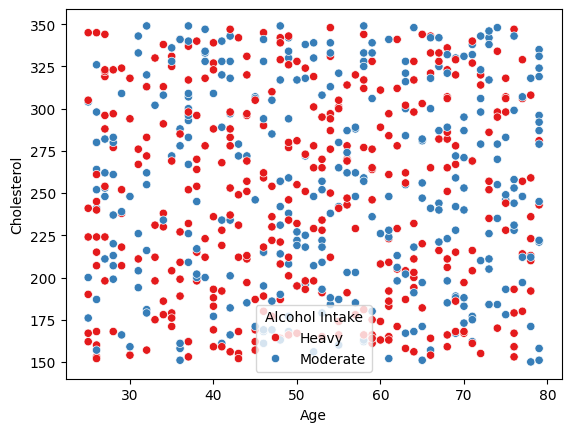

In [12]:
sns.scatterplot(data = data, x = 'Age', y= 'Cholesterol', hue='Alcohol Intake', palette='Set1')

In [14]:
from scipy.stats import f_oneway
numeric_cols = data.select_dtypes(include="int64").columns.drop("Heart Disease")
anova_results = {}

for col in numeric_cols:
    groups = [
        group[col].dropna()
        for name, group in data.groupby("Alcohol Intake")
    ]
    f_stat, p = f_oneway(*groups)
    anova_results[col] = p

anova_results


{'Age': np.float64(0.015845911086778113),
 'Cholesterol': np.float64(0.17014462296382488),
 'Blood Pressure': np.float64(0.7684155172120806),
 'Heart Rate': np.float64(0.9563004381422258),
 'Exercise Hours': np.float64(0.8925692953728638),
 'Stress Level': np.float64(0.952237787756792),
 'Blood Sugar': np.float64(0.8333464709617395)}

In [18]:
from scipy.stats import chi2_contingency
cat_cols = data.select_dtypes(include="object").columns.drop("Alcohol Intake")
chi_results_alcohol = {}

for col in cat_cols:
    table = pd.crosstab(data["Alcohol Intake"], data[col])
    chi2, p, _, _ = chi2_contingency(table)
    chi_results_alcohol[col] = p

chi_results_alcohol


{'Gender': np.float64(0.7984563436272437),
 'Smoking': np.float64(0.8950137908058824),
 'Family History': np.float64(0.3912475270611989),
 'Diabetes': np.float64(1.0),
 'Obesity': np.float64(0.3938641292692874),
 'Exercise Induced Angina': np.float64(1.0),
 'Chest Pain Type': np.float64(0.6372722195370355)}

In [19]:
import numpy as np

def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    return np.sqrt(chi2 / (n * (min(table.shape) - 1)))

cramers_results = {}

for col in cat_cols:
    table = pd.crosstab(data["Alcohol Intake"], data[col])
    cramers_results[col] = cramers_v(table)

cramers_results


{'Gender': np.float64(0.009939305914237336),
 'Smoking': np.float64(0.01833329080747177),
 'Family History': np.float64(0.03337258222159043),
 'Diabetes': np.float64(0.0),
 'Obesity': np.float64(0.03318860519648081),
 'Exercise Induced Angina': np.float64(0.0),
 'Chest Pain Type': np.float64(0.05072919816406084)}

| Feature                     | Cramér’s V | Interpretation           |
| --------------------------- | ---------- | ------------------------ |
| **Gender**                  | 0.0099     |  Negligible association |
| **Smoking**                 | 0.0183     |  Very weak association  |
| **Family History**          | 0.0334     |  Very weak association  |
| **Diabetes**                | 0.0000     |  No association         |
| **Obesity**                 | 0.0332     |  Very weak association  |
| **Exercise Induced Angina** | 0.0000     |  No association         |
| **Chest Pain Type**         | 0.0507     |  Very weak association  |


From:

- Chi-square tests
- Cramér’s V (all < 0.1)

We learned:
- Alcohol Intake has very weak or no association with other features
- It is not a dominant predictor
- Missingness is likely random, not systematic

 Therefore, simple imputation is appropriate.

In [21]:
data["Alcohol Intake"] = data["Alcohol Intake"].fillna("Unknown")


---

In [22]:
from sklearn.model_selection import train_test_split

X = data.drop(columns="Heart Disease")
y = data["Heart Disease"]

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [26]:
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.91      0.89       122
           1       0.85      0.78      0.81        78

    accuracy                           0.86       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.86      0.86       200



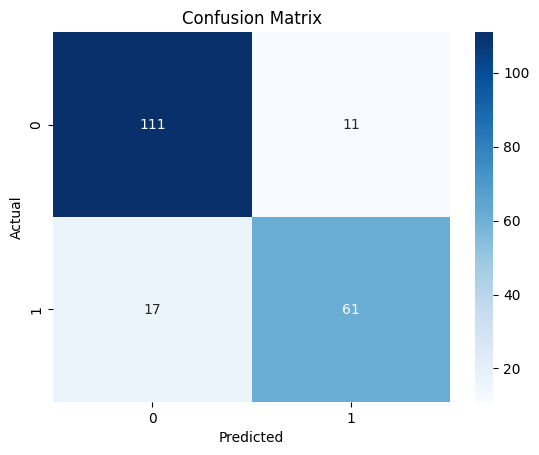

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


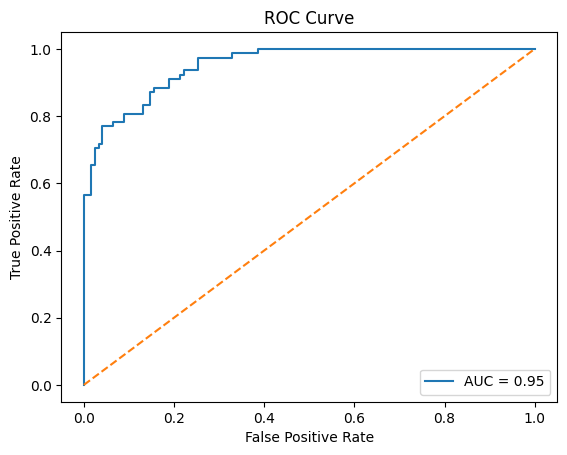

In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## MODEL INTERPRETABILITY

In [30]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
0,Age,3.006553
1,Cholesterol,2.014890
13,Diabetes_Yes,0.203727
7,Gender_Male,0.174038
12,Family History_Yes,0.160230
15,Exercise Induced Angina_Yes,0.090788
18,Chest Pain Type_Typical Angina,0.082069
16,Chest Pain Type_Atypical Angina,0.074503
14,Obesity_Yes,0.040517
2,Blood Pressure,0.032427


In [31]:
coefficients["Odds_Ratio"] = np.exp(coefficients["Coefficient"])
coefficients


,Feature,Coefficient,Odds_Ratio
0,Age,3.006553,20.217593
1,Cholesterol,2.014890,7.499904
13,Diabetes_Yes,0.203727,1.225964
7,Gender_Male,0.174038,1.190101
12,Family History_Yes,0.160230,1.173781
15,Exercise Induced Angina_Yes,0.090788,1.095037
18,Chest Pain Type_Typical Angina,0.082069,1.085530
16,Chest Pain Type_Atypical Angina,0.074503,1.077349
14,Obesity_Yes,0.040517,1.041349
2,Blood Pressure,0.032427,1.032959


Rule of thumb:

- Odds Ratio > 1 → increases heart disease risk
- Odds Ratio < 1 → decreases heart disease risk
- Closer to 1 → weaker effect

### Logistic Regression Interpretation

Logistic regression analysis reveals that age and cholesterol are the most
influential predictors of heart disease. Age exhibits the strongest effect,
with each standardized unit increase associated with a more than 20-fold
increase in disease odds. Cholesterol also demonstrates a substantial impact,
increasing heart disease odds by approximately sevenfold.

Moderate risk contributions are observed for diabetes, male gender, family
history, and exercise-induced angina, while lifestyle factors such as exercise
and smoking status exhibit protective effects. Alcohol intake and stress
levels show minimal standalone influence, consistent with earlier exploratory
and statistical findings.

Overall, the results highlight the multifactorial nature of heart disease,
with both clinical and lifestyle factors contributing to risk.


---

In [40]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)


In [41]:
from sklearn.metrics import classification_report

print(classification_report(y_test, dummy_pred))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76       122
           1       0.00      0.00      0.00        78

    accuracy                           0.61       200
   macro avg       0.30      0.50      0.38       200
weighted avg       0.37      0.61      0.46       200



c:\Users\sapan\OneDrive\Ambiente de Trabalho\Github\Heart-Disease-Prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sapan\OneDrive\Ambiente de Trabalho\Github\Heart-Disease-Prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sapan\OneDrive\Ambiente de Trabalho\Github\Heart-Disease-Prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted

In [42]:
print(confusion_matrix(y_test, dummy_pred))

[[122   0]
 [ 78   0]]


In [36]:
models={
    'Naive Bayes':GaussianNB(),
    'Random Forest Classfier':RandomForestClassifier(n_estimators=20, random_state=12,max_depth=5),
    'K Nearest Neighbors':KNeighborsClassifier(n_neighbors=10),
    'Decision Tree':DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6),
    'Support Vector Machine':SVC(kernel='rbf', C=2)
}

In [39]:
model_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for model_name, model in models.items():

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    #train_accuracy = accuracy_score(x_train,y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f"Model: {model_name}")
    print("Testing Accuracy: ", test_accuracy)
    print("Precision: ",precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)
    print("Confusion Matrix:\n ",confusion_mat)


    model_list.append(model_name)
    accuracy_list.append(test_accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    print("=" * 35)
    print('\n')

max_accuracy_index = accuracy_list.index(max(accuracy_list))
print(f"The best model based on accuracy is {model_list[max_accuracy_index]} with Testing Accuracy: {accuracy_list[max_accuracy_index]}")

Model: Naive Bayes
Testing Accuracy:  0.925
Precision:  0.9436619718309859
Recall:  0.8589743589743589
F1 Score:  0.8993288590604027
Confusion Matrix:
  [[118   4]
 [ 11  67]]


Model: Random Forest Classfier
Testing Accuracy:  0.99
Precision:  1.0
Recall:  0.9743589743589743
F1 Score:  0.987012987012987
Confusion Matrix:
  [[122   0]
 [  2  76]]


Model: K Nearest Neighbors
Testing Accuracy:  0.92
Precision:  0.9558823529411765
Recall:  0.8333333333333334
F1 Score:  0.8904109589041096
Confusion Matrix:
  [[119   3]
 [ 13  65]]


Model: Decision Tree
Testing Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
Confusion Matrix:
  [[122   0]
 [  0  78]]


Model: Support Vector Machine
Testing Accuracy:  0.935
Precision:  0.922077922077922
Recall:  0.9102564102564102
F1 Score:  0.9161290322580645
Confusion Matrix:
  [[116   6]
 [  7  71]]


The best model based on accuracy is Decision Tree with Testing Accuracy: 1.0


In [ ]:
Debcision Tree':DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)

In [45]:
model = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 4)

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model, X, y, cv=5, scoring="f1"
)

scores.mean(), scores.std()


(np.float64(1.0), np.float64(0.0))